# Qubitized Hubbard Select

Subroutines for the SELECT operation for the Hubbard model Hamiltonian.

This module follows section V. of Encoding Electronic Spectra in Quantum Circuits with Linear T
Complexity. Babbush et al. 2018. [arxiv:1805.03662](https://arxiv.org/abs/1805.03662).


The goal is to construct a SELECT operator optimized for the following
Hamiltonian:

$$
\def\Zvec{\overrightarrow{Z}}
\def\hop#1{#1_{p,\sigma} \Zvec #1_{q,\sigma}}
H = -\frac{t}{2} \sum_{\langle p,q \rangle, \sigma} (\hop{X} + \hop{Y})
  + \frac{u}{8} \sum_{p,\alpha\ne\beta} Z_{p,\alpha}Z_{p,\beta}
  - \frac{u}{4} \sum_{p,\sigma} Z_{p,\sigma} + \frac{uN}{4}\mathbb{1}
$$

With these operators, our selection register has indices
for $p$, $\alpha$, $q$, and $\beta$ as well as two indicator bits $U$ and $V$. There are four cases
considered in both the PREPARE and SELECT operations corresponding to the terms in the Hamiltonian:

 - $U=1$, single-body Z
 - $V=1$, spin-spin ZZ term
 - $p<q$, XZX term
 - $p>q$, YZY term.

In [16]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `SelectHubbard`
The SELECT operation optimized for the 2D Hubbard model.

In contrast to SELECT for an arbitrary chemistry Hamiltonian, we:
 - explicitly consider the two dimensions of indices to permit optimization of the circuits.
 - dispense with the `theta` index for phases.

If neither $U$ nor $V$ is set we apply the kinetic terms of the Hamiltonian:

$$
\def\Zvec{\overrightarrow{Z}}
\def\hop#1{#1_{p,\sigma} \Zvec #1_{q,\sigma}}
-\hop{X} \quad p < q \\
-\hop{Y} \quad p > q
$$

If $U$ is set we know $(p,\alpha)=(q,\beta)$ and apply the single-body term: $-Z_{p,\alpha}$.
If $V$ is set we know $p=q, \alpha=0$, and $\beta=1$ and apply the spin term:
$Z_{p,\alpha}Z_{p,\beta}$

`SelectHubbard`'s construction uses $10 * N + log(N)$ T-gates.

#### Parameters
 - `x_dim`: the number of sites along the x axis.
 - `y_dim`: the number of sites along the y axis.
 - `control_val`: Optional bit specifying the control value for constructing a controlled version of this gate. Defaults to None, which means un-controlled. 

#### Registers
 - `control`: A control bit for the entire gate.
 - `U`: Whether we're applying the single-site part of the potential.
 - `V`: Whether we're applying the pairwise part of the potential.
 - `p_x`: First set of site indices, x component.
 - `p_y`: First set of site indices, y component.
 - `alpha`: First set of sites' spin indicator.
 - `q_x`: Second set of site indices, x component.
 - `q_y`: Second set of site indices, y component.
 - `beta`: Second set of sites' spin indicator.
 - `target`: The system register to apply the select operation. 

#### References
 - [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662). Section V. and Fig. 19.


In [17]:
from qualtran.bloqs.chemistry.hubbard_model.qubitization import SelectHubbard

### Example Instances

In [18]:
x_dim = 4
y_dim = 4
sel_hubb = SelectHubbard(x_dim, y_dim)

In [19]:
csel_hubb = sel_hubb.controlled()

#### Graphical Signature

In [20]:
from qualtran.drawing import show_bloqs
show_bloqs([sel_hubb],
           ['`sel_hubb`'])

### Call Graph

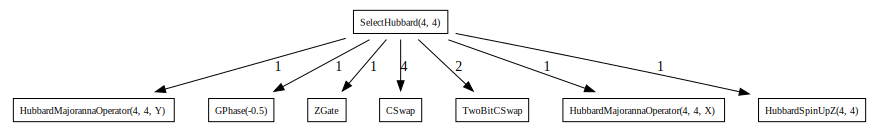

#### Counts totals:
 - `CSwap`: 4
 - `GPhase(-0.5)`: 1
 - `HubbardMajorannaOperator(4, 4, X)`: 1
 - `HubbardMajorannaOperator(4, 4, Y)`: 1
 - `HubbardSpinUpZ(4, 4)`: 1
 - `TwoBitCSwap`: 2
 - `ZGate`: 1

In [21]:
from qualtran.resource_counting.generalizers import ignore_split_join
sel_hubb_g, sel_hubb_sigma = sel_hubb.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(sel_hubb_g)
show_counts_sigma(sel_hubb_sigma)

In [29]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

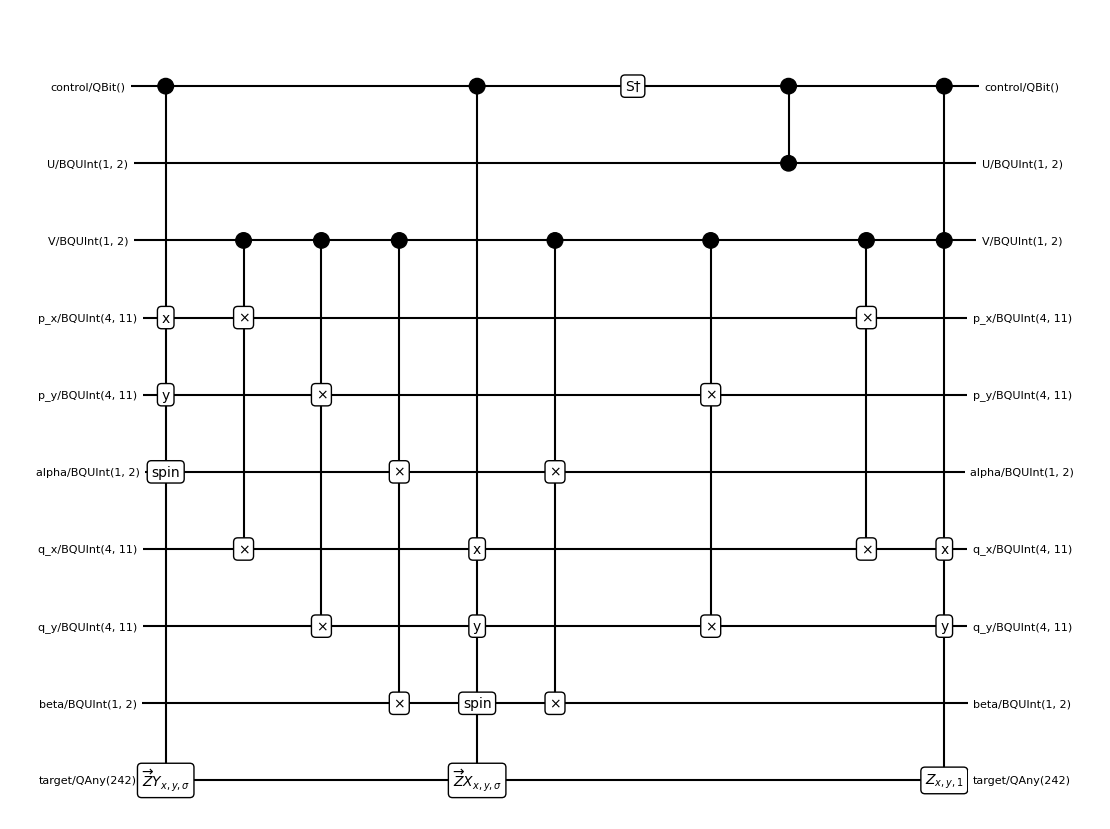

In [33]:
sh = SelectHubbard(x_dim=11, y_dim=11).controlled()
show_bloq(sh.decompose_bloq(), 'musical_score')

## `HubbardMajorannaOperator`
Apply majoranna fermion operation to the Hubbard system.

Specifically apply $\overrightarrow{Z} P_{x,y,\sigma}$ for single-qubit
Pauli $P$.

This is a subroutine of `HubbardSelect`.

This uses $N$ Toffoli gates, where `N=2*x_dim*y_dim`.

#### Parameters
 - `x_dim`: the number of sites along the x axis.
 - `y_dim`: the number of sites along the y axis.
 - `gate`: Either "X" or "Y" to do the corresponding Majoranna operation.
 - `control_val`: Optional bit specifying the control value for constructing a controlled version of this gate. Defaults to None, which means un-controlled. 

#### Registers
 - `x`: Site indices, x component.
 - `y`: Site indices, y component.
 - `spin`: Sites' spin indicator. 

#### References
 - [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662). Section V. and Fig. 19, "Majoranna operators". See also Figure 9.


In [23]:
from qualtran.bloqs.chemistry.hubbard_model.qubitization import HubbardMajorannaOperator

### Example Instances

In [ ]:
n = sympy.Symbol('n')
hubb_majoranna = HubbardMajorannaOperator(x_dim=n, y_dim=n, gate='X', control_val=1)

In [ ]:
hubb_majoranna_small = HubbardMajorannaOperator(x_dim=3, y_dim=3, gate='Y')

#### Graphical Signature

In [ ]:
from qualtran.drawing import show_bloqs
show_bloqs([hubb_majoranna, hubb_majoranna_small],
           ['`hubb_majoranna`', '`hubb_majoranna_small`'])

## `HubbardSpinUpZ`
Phase the spin up subspace of the Hubbard system.

Specifically, apply $Z_{q,1}$.

In combination with the `HubbardMajorannaOperator` subroutines, this applies the spin term
$Z_{p,\alpha}Z_{p,\beta}$ if $V$ is set. This is a subroutine of `HubbardSelect`.

This uses $N/2$ Toffoli gates, where `N=2*x_dim*y_dim`.

#### Parameters
 - `x_dim`: the number of sites along the x axis.
 - `y_dim`: the number of sites along the y axis.
 - `control_val`: Optional bit specifying the control value for constructing a controlled version of this gate. Defaults to None, which means un-controlled. 

#### Registers
 - `V`: Whether we're applying the pairwise part of the potential. If not set, this bloq does nothing.
 - `x`: Site indices, x component.
 - `y`: Site indices, y component. 

#### References
 - [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662). Section V. and Fig. 19, last operation; which references Fig 7.


In [ ]:
from qualtran.bloqs.chemistry.hubbard_model.qubitization import HubbardSpinUpZ

### Example Instances

In [ ]:
n = sympy.Symbol('n')
hubb_spin_up_z = HubbardSpinUpZ(x_dim=n, y_dim=n, control_val=1)

In [ ]:
hubb_spin_up_z_small = HubbardSpinUpZ(x_dim=3, y_dim=3)

#### Graphical Signature

In [ ]:
from qualtran.drawing import show_bloqs
show_bloqs([hubb_spin_up_z, hubb_spin_up_z_small],
           ['`hubb_spin_up_z`', '`hubb_spin_up_z_small`'])